# Employee Turnover Analysis

# Executive Summary
- Approach people who work fewer than 178 hours and between 185 and 190 hours. Working between 185 and 190 hours increases the risk of leaving by 167% and therefore this is the potentially biggest lever to reduce employee turnover.

- Offer new career opportunities to qualified candidates more frequently. By promoting an employee the likelihood of leaving can be reduced by 33%.  

- Conduct further examinations of employees in different departments, for example IT and finance. As employees in the finance department are 12.9% less likely to quit than their counterparts in the IT department, one needs understand the needs of IT employees better. 

- Interview employees particularly with a tenure between 7-8 and 5-6 years to determine the reasons they are looking for new opportunities.

- Forecast whether an employee will be leaving with an accuracy of 74%. This should be used to approach at-risk employees.

- Approach employees identified by the previous predictors, instead of relying on satisfaction surveys to detemrine what they might be looking for in other jobs. 

- In the future, calculate the cost of losing an employee and devoting additional resources to at-risk employees to optimize how much additional efforts should be allocated to keeping employees.

# Analysis
## Set-up

In [1]:
# Install dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
# Import data
data = pd.read_csv('./data/employee_churn_data.csv')

In [ ]:
# Create copy of data to so that "data" always is the original input
df = data.copy()
# Turn "left" variable to binary for easier calculation 
df["left"] = df["left"].replace(["no", "yes"], [0,1])

### Overall Employee Turnover

In [ ]:
# Total labor turnover
print("Total labor turnover:", end=" ")
print(round(df["left"].sum() / df["left"].count() * 100, 2), "%", sep="")

Total labor turnover: 29.18%


A labor turnover of 29.18% is almost double the US average of 18% [1].

### Employee Turnover by Department

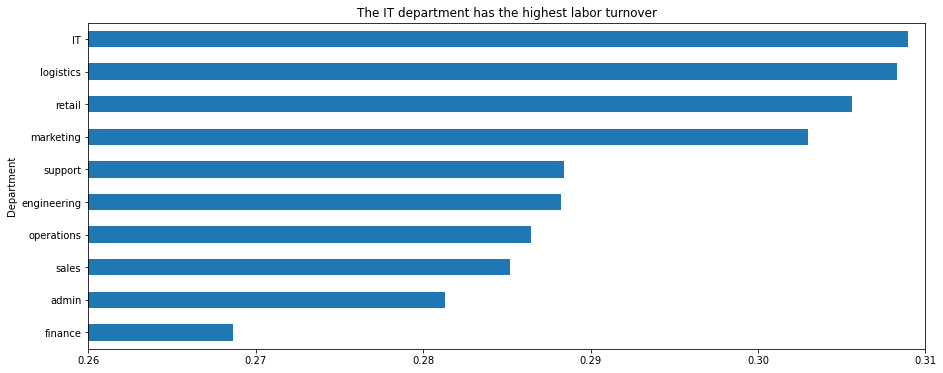

In [ ]:
# Visualize turnover by department
plt.figure(figsize=(15,6))

# Group by department and calculate percentage of people leaving
df.groupby("department").agg(np.mean).sort_values("left", ascending=True)["left"].plot(kind="barh", title="The IT department has the highest labor turnover", xlabel="Department", ylabel="Turnover rate")
ax = plt.gca()
ax.set_xlim([0.26,0.31])

plt.show()

While the IT department has the highest labor turnover at 30.9%, the finance department has the lowest at 26.9%. This indicates that for identifying ways to reduce labor turnover it might be helpful to identify differences between the finance department and the other departments.

### Identifying Important Predictors
**Analysis of Categorical Variables**

The categorical variables promoted, salary, and bonus are analyzed independently of the rest of variables to identify archetypes of employees that are more likely to leave. 

In [ ]:
# Create alluvial diagram to show categorical variables and conditional probabilities of leavin company to identify differences

# Create dimensions
promoted_dim = go.parcats.Dimension(values=data["promoted"], label="Promoted", categoryarray=[0, 1], ticktext=['no', 'yes'])
salary_dim = go.parcats.Dimension(values=data["salary"], label="Salary", categoryarray=["high", "medium", "low"])
projects_dim = go.parcats.Dimension(values=data["projects"], label="Projects", categoryorder='category ascending')
bonus_dim = go.parcats.Dimension(values=data["bonus"], label="Bonus", categoryarray=[1, 0], ticktext=['bonus', 'no bonus'])
left_dim = go.parcats.Dimension(values=data["left"], label="Left", categoryarray=["no", "yes"], ticktext=['stayed', 'left'])

# Create parcats trace
color = df["left"].replace(["no", "yes"], [0,1])
colorscale = [[0, 'lightsteelblue'], [1, 'mediumseagreen']]

fig = go.Figure(data = 
        [go.Parcats(dimensions=[promoted_dim, salary_dim, bonus_dim, left_dim],
        line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
		bundlecolors=True,
        arrangement='freeform')])

fig.show()

Considering only categorical variables, the probability of an employee leaving only changes more than 2-3% when promoted in the last 24 months. Specifically, the probability of an employee leaving falls from 29.5% to 19.7% after being promoted. The majority of those who left (55%), were not promoted, had a medium income and did not receive a bonus.

### Analysis of relative strength of predictors

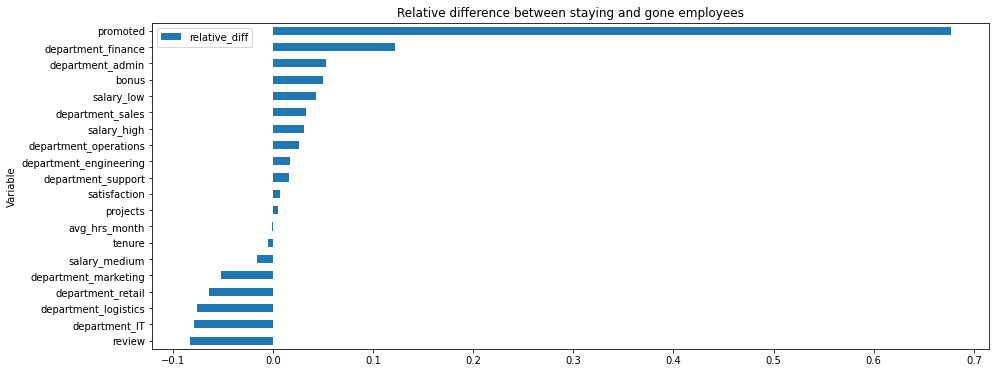

In [ ]:
# Determine how employees staying in the company and leaving it are different

# Convert categorical variables to dummy variables to see impact of each selection
df_dummy = pd.get_dummies(df)

# Create columns with mean for each category for employees who left and stayed
df_mean = pd.DataFrame()
df_mean["left"] = df_dummy[df_dummy["left"]==1].mean()
df_mean["stayed"] = df_dummy[df_dummy["left"]==0].mean()
df_mean["relative_diff"] = df_mean["stayed"] / df_mean["left"] - 1
df_mean = df_mean.reset_index().sort_values("relative_diff")

df_mean[df_mean["index"]!="left"].plot(kind="barh", x="index", y="relative_diff", xlabel="Variable", title="Relative difference between staying and gone employees", figsize=(15,6) )
plt.show()

The group of staying employees are 67% more likely to have had a promotion than the ones who left. Additionally, staying employees are 12% more likely to be in the finance department, 5% more in the admin department, and 5% more likely to have received a bonus. On the other hand, they got 8% worse reviews.

### Analysis of Working Hours

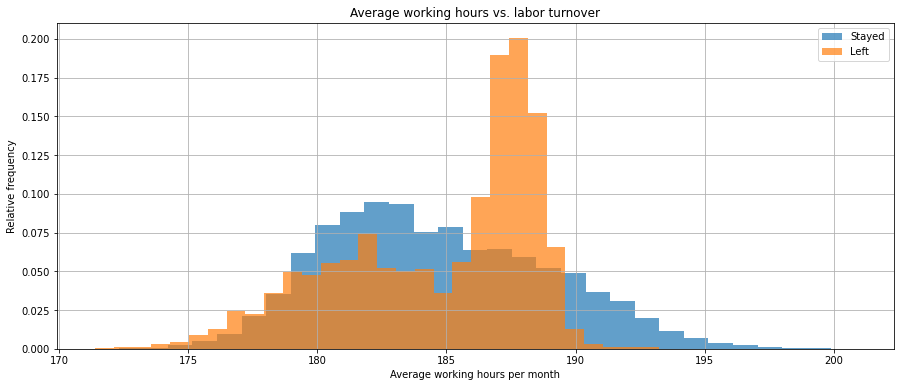

Relative frequency of working between 186 and 188 hours when leaving vs. when staying 167.49%


In [ ]:
# Conditional probability given "left" to identify interaction of work hours and labor turnover
plt.figure(figsize=(15,6))

df[df["left"] == 0]["avg_hrs_month"].hist(alpha=0.7, density=True, bins=30)
df[df["left"] == 1]["avg_hrs_month"].hist(alpha=0.7, density=True, bins=30)
plt.legend(["Stayed", "Left"])
plt.title("Average working hours vs. labor turnover")
plt.xlabel("Average working hours per month")
plt.ylabel("Relative frequency")
plt.show()

n = np.count_nonzero(df[df["left"]==0]["department"])
s = np.count_nonzero(df[df["left"]==1]["department"])

pr_s = np.count_nonzero(df[(df["avg_hrs_month"] > 186) & (df["avg_hrs_month"] < 188) & (df["left"] == 0)]["department"]) / n
pr_l = np.count_nonzero(df[(df["avg_hrs_month"] > 186) & (df["avg_hrs_month"] < 188) & (df["left"] == 1)]["department"]) / s
print("Relative frequency of working between 186 and 188 hours when leaving vs. when staying {}%".format(round(((pr_l / pr_s)-1) * 100, 2)))

Interestingly, employees who left, have most likely worked between 186 and 188 hours, while employees who stayed have most likely worked between 181 and 184 hours. The probability that somebody worked between 186 and 188 hours is 167% higher when they left the company. Additionally, employees who worked the longest hours never left and employees who worked the shortest hours never stayed.

### Analysis of Satisfaction

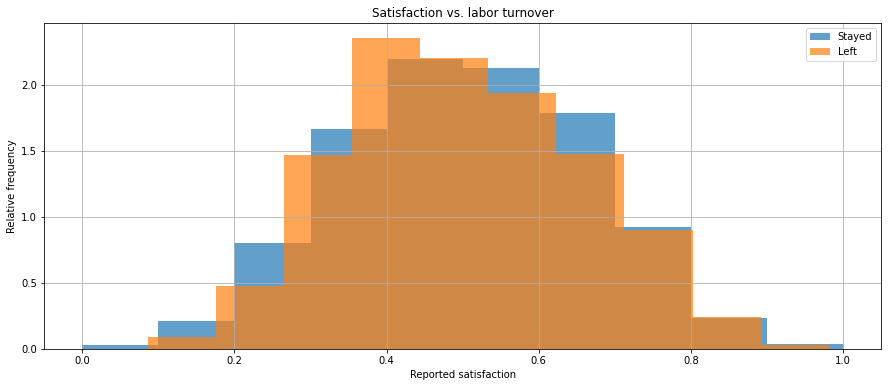

In [ ]:
# Conditional probability given "left" to identify interaction of satisfaction and labor turnover
plt.figure(figsize=(15,6))

df[df["left"] == 0]["satisfaction"].hist(alpha=0.7, density=True)
df[df["left"] == 1]["satisfaction"].hist(alpha=0.7, density=True)
plt.legend(["Stayed", "Left"])
plt.title("Satisfaction vs. labor turnover")
plt.xlabel("Reported satisfaction")
plt.ylabel("Relative frequency")
plt.show()

There is no significant difference between the reported satisfaction of people leaving and people staying. This could indicate either that satisfaction really does not affect why employees switch jobs or, more likely, that the self-reported measure does not uncover the underlying issues employees have with their work.

### Analysis of Tenure

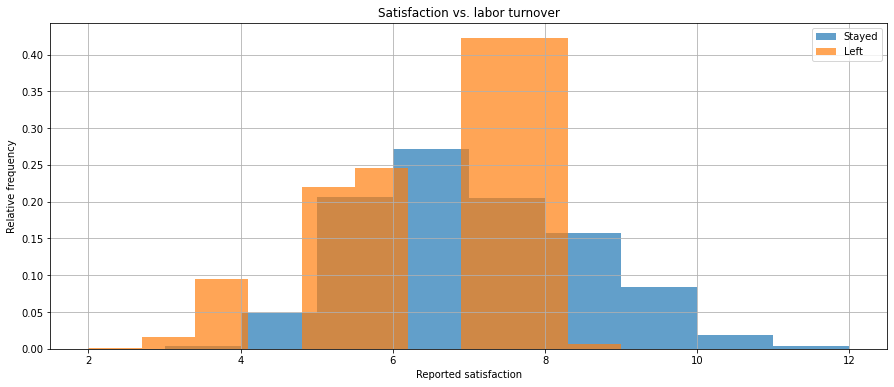

In [85]:
# Conditional probability given "left" to identify interaction of tenure and labor turnover
plt.figure(figsize=(15,6))

df[df["left"] == 0]["tenure"].hist(alpha=0.7, density=True)
df[df["left"] == 1]["tenure"].hist(alpha=0.7, density=True)
plt.legend(["Stayed", "Left"])
plt.title("Satisfaction vs. labor turnover")
plt.xlabel("Reported satisfaction")
plt.ylabel("Relative frequency")
plt.show()

There are three main times for people to leave the company. At 3-4, 5-6, and 7-8 years while 7-8 years is the most likely time period to leave.

### Logistic Regression
To prevent future labor turnover, it is crucial that HR can predict which employees might be prone to leaving the company. Therefore, we estimate the probability of an employee leaving using logistic regression, based on all features of the dataset.

In [ ]:
# Logistic regression to evaluate predictive abilities of variables

# define the predictor variables and the response variable
X = df_dummy.loc[:, df_dummy.columns!='left']
y = df_dummy['left']

# split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)  

# instantiate the model
log_reg = LogisticRegression()

# fit the model using the training data
log_reg.fit(X_train,y_train)

# use model to make predictions on test data
y_pred = log_reg.predict(X_test)

# Evaluate model:
# True positive predictions: (1,1)
# True negative predictions: (2,2)	
# False positive predictions: (2,1)
# False negative predictions: (1,2)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cnf_matrix)

print("\nAccuracy: ",round(metrics.accuracy_score(y_test, y_pred), 2))
print("Employee leaving accuracy: ", round(cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]),2))

Confusion matrix:
[[1918   72]
 [ 730  142]]

Accuracy:  0.72
Employee leaving accuracy:  0.16


The model correctly predicts whether an employee will leave or stay with an accuracy of **72%** but only correctly classifies **16%** of the employees that actually left.

Lastly, we can plot the ROC (Receiver Operating Characteristic) Curve which displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes:

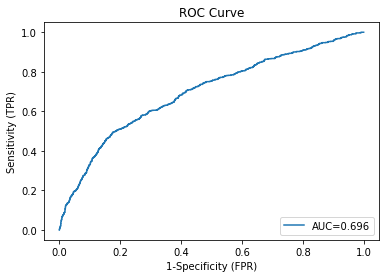

In [ ]:
#define metrics
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 3)))
plt.xlabel("1-Specificity (FPR)")
plt.ylabel("Sensitivity (TPR)")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

Using all variables as predictors, an **AUC of 0.696** is achieved. This indicates that it is difficult to distinguish between employees who will leave and those who will stay. As it is likely more costly to lose an employee than to intervene with more employees, we can reduce the threshold at which we classify an employee as at risk.

In [ ]:
# Select a different classification threshold to improve the accuracy of forecasting leaving employees
pred_proba_df = pd.DataFrame(log_reg.predict_proba(X_test))
threshold_list = [0.25]

for i in threshold_list:
    print ('******** For threshold = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred[1])
    print('Our testing accuracy is {}'.format(round(test_accuracy, 2)))
    cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred[1])
    print("Confusion matrix:")
    print(cnf_matrix)
    print("Employee leaving accuracy: ", round(cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]),2))

******** For threshold = 0.25 ******
Our testing accuracy is 0.59
Confusion matrix:
[[1049  941]
 [ 225  647]]
Employee leaving accuracy:  0.74


After testing different threshold values, we choose 0.25 as a good trade-off between overall prediction accuracy and prediction accuracy of employees leaving. Given the cost of losing an employee and giving an at-risk employee additional attention, this threshold can be optimized to reduce labor costs.

# Conclusions
- Approach people who work fewer than 178 hours and between 185 and 190 hours. Working between 185 and 190 hours increases the risk of leaving by 167% and therefore this is the potentially biggest lever to reduce employee turnover. Discussing their dislikes and opportunities with these employees can help to identify and eliminate reasons to leave. People who work more than 190 hours are less likely to leave. This could be due to intrinsic motivation and enjoyment of the work.

- Offer new career opportunities to qualified candidates more frequently. By promoting an employee the likelihood of leaving can be reduced by 33%. This would likely satisfy their need for self-actualization. Additionally, making career opportunities visible can help employees to understand their potential path at the company which is likely to increase their motivation and loyalty to the company.

- Further examinations of personal preferences should be conducted in the different departments, for example IT and finance. As employees in the finance department are 12.9% less likely to quit than their counterparts in the IT department, one needs understand the needs of IT employees better. 

- Interview employees particularly with a tenure between 7-8 and 5-6 years to determine the reasons they are looking for new opportunities. This might include starting a family or looking for steeper career growth. 

- We can forecast the whether an employee will be leaving with an accuracy of 74%. This should be used to approach at-risk employees. A subset of predicted employees can be targeted to evoke additional motivation and discuss their needs at the workplace.

- Instead of relying on satisfaction surveys, the board should talk to people identified by the earlier methods to identify what they might be looking for in other jobs. The satisfaction survey results have been shown to be unreliable in forecasting an employees likelihood to stay.

- In the future, the board should calculate the cost of losing an employee and devoting additional resources to at-risk employees to optimize how much additional efforts should be allocated to keeping employees.

## References
[1] Ariella, Sky (2021). 27 US EMPLOYEE TURNOVER STATISTICS: AVERAGE EMPLOYEE TURNOVER RATE, INDUSTRY COMPARISONS, AND TRENDS. Online at: https://www.zippia.com/advice/employee-turnover-statistics/